## Downloading dataset

In [1]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/gwbz3fsgp8-2.zip

--2022-05-14 02:18:13--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/gwbz3fsgp8-2.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.116.42
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.116.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203349349 (194M) [application/octet-stream]
Saving to: ‘gwbz3fsgp8-2.zip’

gwbz3fsgp8-2.zip    100%[===================>] 193.93M  20.9MB/s    in 10s     

2022-05-14 02:18:24 (19.1 MB/s) - ‘gwbz3fsgp8-2.zip’ saved [203349349/203349349]



In [2]:
import torch
print(torch.__version__)

1.11.0+cu113


In [ ]:
!unzip /content/gwbz3fsgp8-2.zip -d dataset

In [4]:
import glob
import json
import math
import os
import random
import shutil
from os import listdir
from os.path import isfile, join
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage import io, transform

In [5]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision as vision
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

In [6]:
class CropImage():
    def __call__(self, image):
    # print(image)
        h, w = image.size
        new_img = None

        area = (72, 287, w - 40, h - 60)
        new_img = image.crop(area)

        return new_img

In [7]:
def prepare_dataset(dataset_path):
    """ Function to create train and validation loader.
    Params:
        dataset_path: path where all images are.

    returns: 
        train_loader: train loader with batch size of 8
        validation_loader: validation loader with batch size of 32

    Note: Split ratio and batch sizes are pre-defined you can change it in this function.
    """

    labels = os.listdir(dataset_path)

    # Here images are resized and converted to grayscale so that we have data consistency for other tasks
    dataset = ImageFolder(
      dataset_path,
      transforms.Compose([CropImage(),
          transforms.Resize((512,512)),
                         transforms.ToTensor()
                         ])
    )

    # Validation split 15%
    val_split = int(len(dataset)*0.20)
    train_split = len(dataset) - val_split

    train_dataset, val_dataset = random_split(dataset, [train_split, val_split])

    # to make sure the split is right.
    assert (len(train_dataset)+len(val_dataset)) == len(dataset)

    train_loader = torch.utils.data.DataLoader(train_dataset, 8, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(val_dataset, 32) 

    return (train_loader, validation_loader)

In [8]:
dataset_dir = "./dataset"
train_loader, validation_loader = prepare_dataset(dataset_dir)

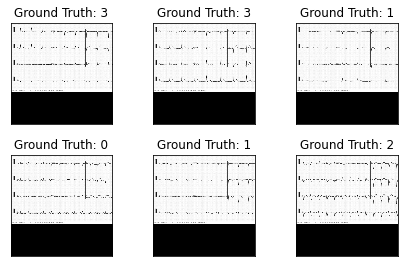

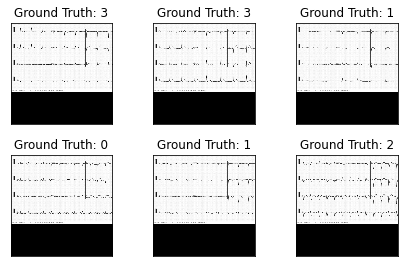

In [9]:
examples = enumerate(validation_loader)
batch_idx, (example_data, example_targets) = next(examples)
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [10]:
classnames= ['ECG Images of Patient that have abnormal heartbeat (233x12=2796)',
                             'Normal Person ECG Images (284x12=3408)',
                             'ECG Images of Myocardial Infarction Patients (240x12=2880)',
                             'ECG Images of Patient that have History of MI (172x12=2064)']

In [11]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'squeezenet1_0', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

In [12]:
feature_extract = True
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

model_ft = model
set_parameter_requires_grad(model_ft, feature_extract)

num_classes = 4

model_ft.classifier = nn.Sequential(
    nn.Conv2d(512, 256, kernel_size=(1), stride=(1,1)),
    nn.Conv2d(256, 128, kernel_size=(1,1), stride=(1,1)),
    nn.Conv2d(128, num_classes, kernel_size=(1,1), stride=(1,1)),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
)


In [13]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=1e-3, weight_decay=1e-4)
if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	model = model_ft.cuda()
	criterion = criterion.cuda()

Tesla T4


In [14]:
%%time
# Loss and accuracy list are defined, these lists are used for graph.
train_loss_list = []
val_loss_list = []
epc_list = []
train_acc_list = []
val_acc_list = []

def train():
# best_valid_loss is defined so as to save the best validation loss which is lowest one.
    best_valid_loss = float('Inf')

    print("Training Started !!!")
    for i in range(25):
        training_loss = 0
        tcorrect = 0
        ttotal = 0
        model.train()
        for features, labels in train_loader:
          # Label and features assigning
          features, labels = Variable(features.cuda()), Variable(labels.cuda())
          optimizer.zero_grad()

          # Output collection from model
          # print(features.size())
          outputs = model(features.float())

          # Loss calculation and updation
          losss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())
          losss.backward()
          optimizer.step()
          training_loss += losss.item()
          # Prediction
          _, pred = torch.max(outputs, 1)
          ttotal+= labels.reshape(-1).size(0)
          tcorrect+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

        # Validation step starts from here.
        validation_loss = 0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
          for features, labels in validation_loader:
            # Label and features assigning
            features, labels = Variable(features.cuda()), Variable(labels.cuda())

            # Output collection from model
            outputs = model(features.float())

            # Loss calculation, here we skip the backward and 
            # optimizer step as we do not update weights while validating a model
            loss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())

            # Prediction
            _, pred = torch.max(outputs, 1)
            total+= labels.reshape(-1).size(0)
            correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
            validation_loss += loss.item()


        train_loss_list.append(training_loss/len(train_loader))
        val_loss_list.append(validation_loss/len(validation_loader))
        epc_list.append(i)
        train_acc_list.append(100*(tcorrect/ttotal))
        val_acc_list.append(100*(correct/total))

        # Logic was defined so as to save the weights of mnist_model when validation loss is lowest.
        # if best_valid_loss > validation_loss:
        #     best_valid_loss = validation_loss 
        #     # Saving Best Pre-Trained Model as .pth file
        #     torch.save(model, "vit1.pth")

        print("Epoch {} - \nTraning loss: {}".format(i+1, training_loss/len(train_loader)))
        print("Validation loss: {}".format( validation_loss/len(validation_loader)))
        print("Trainig Accuracy: {}".format( 100*(tcorrect/ttotal)))
        print("Validation Accuracy: {}".format(100*(correct/total)))

train()

print("Training Complete")

Training Started !!!


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 1 - 
Traning loss: 1.1771044276093925
Validation loss: 0.9377151131629944
Trainig Accuracy: 47.51009421265142
Validation Accuracy: 58.37837837837838
Epoch 2 - 
Traning loss: 0.7954689256286108
Validation loss: 0.7790683408578237
Trainig Accuracy: 67.56393001345896
Validation Accuracy: 71.89189189189189
Epoch 3 - 
Traning loss: 0.6146552413702011
Validation loss: 0.6657008826732635
Trainig Accuracy: 76.58142664872139
Validation Accuracy: 78.37837837837837
Epoch 4 - 
Traning loss: 0.5234954297061889
Validation loss: 0.573660766084989
Trainig Accuracy: 80.48452220726783
Validation Accuracy: 81.62162162162161
Epoch 5 - 
Traning loss: 0.42395245852649854
Validation loss: 0.5064073354005814
Trainig Accuracy: 85.46433378196501
Validation Accuracy: 87.56756756756758
Epoch 6 - 
Traning loss: 0.32910800428800685
Validation loss: 0.5274497618277868
Trainig Accuracy: 89.77119784656796
Validation Accuracy: 84.86486486486487
Epoch 7 - 
Traning loss: 0.2840350764372977
Validation loss: 0.596682

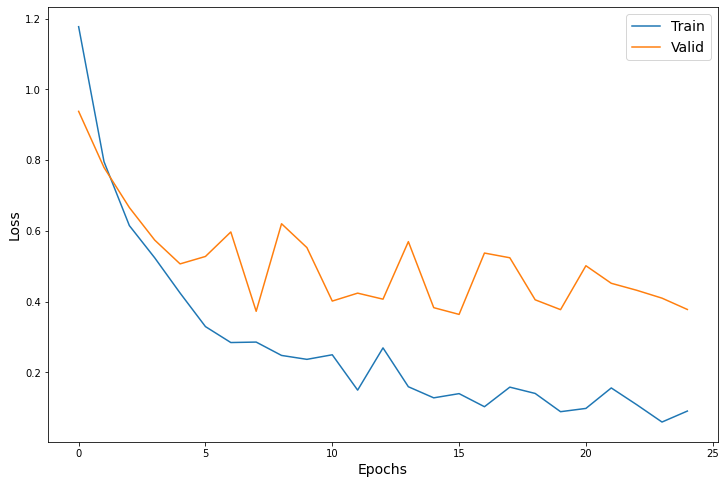

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(epc_list, train_loss_list, label='Train')
plt.plot(epc_list, val_loss_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

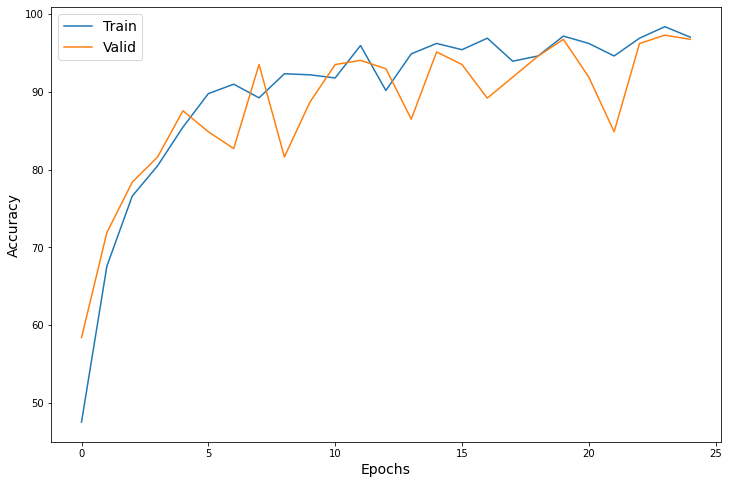

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(epc_list, train_acc_list, label='Train')
plt.plot(epc_list, val_acc_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [17]:
torch.save(model.state_dict(), "./model_dict1.pth")

## Optimize for mobile

In [18]:
import torch
import torchvision
# from unet import UNet 
from torch.utils.mobile_optimizer import optimize_for_mobile
model_ft.load_state_dict(torch.load("model_dict1.pth"))
model_ft.eval()
model = model_ft.to("cpu")
example = torch.rand(1, 3, 512, 512)
traced_script_module = torch.jit.trace(model, example)
traced_script_module = optimize_for_mobile(traced_script_module)
traced_script_module._save_for_lite_interpreter("model_lit1.pt")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
